In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Display the row's columns and data in dictionary format for measurment class
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x248f1a62cf8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# Display the row's columns and data in dictionary format for station class
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x248f1a78b70>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

# Climate Analysis and Exploration
***

## Precipitation Analysis
### Design a query to retrieve the last 12 months of precipitation data and plot the results

- Calculate the date 1 year ago from the last data point in the database

In [12]:
# Grab last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_date)

2017-08-23


In [13]:
# Grab start of last 12 months
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(start_date)

2016-08-23


- Perform a query to retrieve the data and precipitation scores

In [14]:
# Query to pull last 12 months of precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
       filter(Measurement.date >= start_date).\
       order_by(Measurement.date).all()

- Save the query results as a Pandas DataFrame and set the index to the date column

In [15]:
# Load data from the query into a dataframe
prcp_df = pd.DataFrame(prcp)
prcp_df.set_index("date").head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


- Sort the dataframe by date

In [16]:
# Date sort
date = prcp_df.sort_values(by="date",ascending=False)
date.head()

,date,prcp
2229,2017-08-23,0.45
2228,2017-08-23,0.08
2227,2017-08-23,0.00
2226,2017-08-23,0.00
2225,2017-08-22,0.50


- Use Pandas Plotting with Matplotlib to plot the data


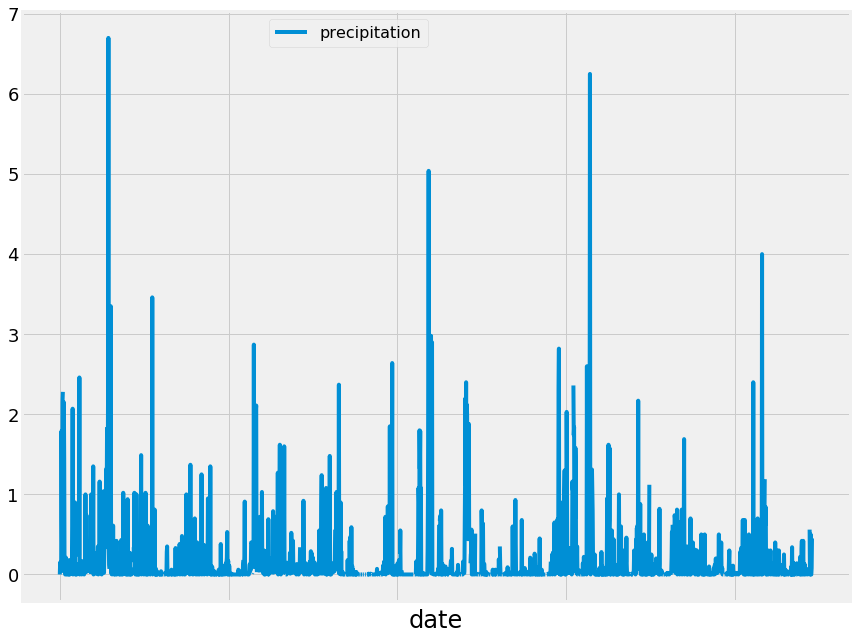

In [17]:
# plot the dataframe
prcp_df.plot("date", "prcp", figsize=(12,9))
plt.tick_params(axis="y", labelsize=18)
plt.xlabel("date", size=24)
plt.legend(["precipitation"], bbox_to_anchor=(.5,1), fontsize="16")
plt.tight_layout()
plt.show()

- Use Pandas to calcualte the summary statistics for the precipitation data

In [18]:
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

### Design a query to calculate the total number of stations

In [19]:
# Total number of stations
session.query(func.count(Station.id)).all()

[(9)]

### Design a query to find the most active stations

- List the stations and the counts in descending order

In [20]:
# Query for stations with the most rows
station_list = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

- Calculate the lowest temperature recorded, highest temperature recorded, and average temperature for the most active station


In [21]:
# Using the station list from the previous query for most active station
most_active = station_list[0][0]
session.query(func.min(Measurement.tobs) , func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

### Design a query to retrieve the last 12 months of temperature observation data (tobs)

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
temp = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= start_date).all()
tobs_df = pd.DataFrame(temp)
tobs_df.set_index("station").head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


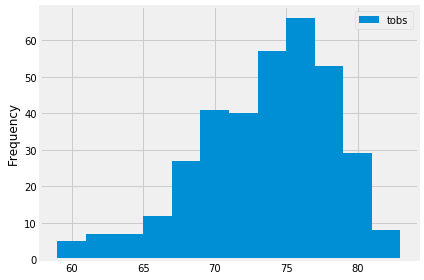

In [23]:
# Plot the results as a histogram with bins=12
plt.hist(tobs_df["tobs"], bins=12)
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

## Temperature Analysis

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


- Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year

In [25]:
# Find matching dates from the previous year
prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)
print(prev_year_end)
print(prev_year_start)

2017-01-07
2017-01-01


In [26]:
# Calculate the tmin, tavg, and tmax for trip using previous year's data for those same dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps("2017-01-01", "2017-01-07"))

[(62.0, 68.36585365853658, 74.0)]


In [27]:
# load the results into individual variables
temps = calc_temps(prev_year_start,prev_year_end)
tmin, tavg, tmax = temps[0]

- Plot the min, avg, and max temperature from your previous query as a bar chart
    - Use the average temperature as the bar height
    - Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

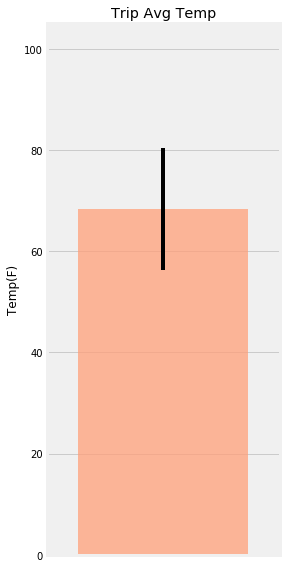

In [28]:
# Plot previous query as a bar chart
# Use "Trip Avg Temp" as your Title
error = tmax - tmin
xpos = 1
height = tavg
plt.figure(figsize=(4,8))
plt.bar(xpos,height, yerr=error, alpha = 0.75, color = "lightsalmon")
plt.xticks([])
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.xlim(0.45,1.55)
plt.ylim(0,105)
plt.show()